In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
import matplotlib.patches as mpatches

In [2]:
cwd = os.getcwd()

In [3]:
seq_path = os.path.join(cwd,'Sequence/src')

#### Step 1: Calculating the area difference from ideal investment

In [4]:
sequence_df = pd.read_parquet(os.path.join(seq_path, 'sequence.parquet'))
criterias = list(sequence_df.columns)

In [12]:
sequence_df

,depth,area_ind,area_sector
0,165250724,1266908852,198335271
1,165242801,72888152,1266908852
2,171267263,198335271,165250724
3,198335271,165250724,165242801
4,72888152,165242801,171267263
5,23135620,171267263,23135620
6,1266908852,23135620,72888152


In [5]:
def area_ideal_dev(criteria, seq_path):


    filepath = os.path.join(seq_path, f'CBA_results_{criteria}.xlsx')
    CBA = pd.read_excel(filepath, index_col = [0])
        
    min_EC = CBA.EAC.min()
    max_EC= CBA.EAC.max()
    min_inv = CBA.INV.min()
    max_inv = CBA.INV.max()

    # Calulating area
    inv_values = CBA['INV']
    tc_values = CBA['EAC']
    
    # Diagonal line with slope and intercept
    slope = (min_EC - max_EC) / (max_inv - min_inv)
    diag_values = max_EC + slope * (inv_values - min_inv)

    # Area positive (above the ideal line)
    diff_pos = np.maximum(tc_values - diag_values, 0)
    area_pos = np.trapz(diff_pos, inv_values)

    # Area negative (below the ideal line)
    diff_neg = np.maximum(diag_values - tc_values, 0)
    area_neg = np.trapz(diff_neg, inv_values)

    area = area_neg - area_pos
    return area

In [6]:
area_df = pd.DataFrame()

for i in range(len(criterias)):
    criteria = criterias[i]
    area = area_ideal_dev(criteria, seq_path)
    area_df.loc[i, 'sequence'] = criteria
    area_df.loc[i, 'area'] = area

In [7]:
area_df

,sequence,area
0,depth,0.006357
1,area_ind,-0.014586
2,area_sector,0.033045


In [8]:
#colors = ['#a53860' , '#3d405b', '#ff7d00', '#7f4f24', '#fcbf49', '#76c893', '#250902']
colors = ['#a53860' , '#3d405b', '#7f4f24']

In [9]:
#criteria_names= ['Flood depth', 'Flood frequency', 'Industrial proximity', 'Industrial proximity \nSector - Oil & Petrochemicals']

In [10]:
titles  = ['(a) Maximum flood depth' , '(b) Sector independent proximity \n to industrial sites ','(c) Proximity to industrial sites \n of Oil andChemicals']

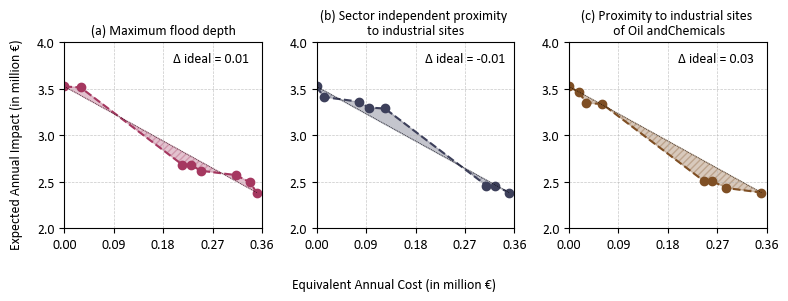

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

# Suppose you have a list of 7 criteria
criteria_list = criterias
area_values = []
seq_names = []

# Set global font properties
mpl.rcParams['font.family'] = 'Calibri'  # or 'Arial', 'Times New Roman', etc.
mpl.rcParams['font.size'] = 10  


# Set up figure and gridspec
fig = plt.figure(figsize=(8, 3))
gs = GridSpec(1, 3, figure=fig, height_ratios=[1])

# Plot first 7 criteria
for i, crit in enumerate(criteria_list):
    row = i
    ax = fig.add_subplot(gs[row])

    filepath = os.path.join(seq_path, f'CBA_results_{crit}.xlsx')
    CBA = pd.read_excel(filepath, index_col=0)

    inv_values = CBA['INV']
    tc_values = CBA['EAC']
    
    min_EC = tc_values.min()
    max_EC = tc_values.max()
    min_inv = inv_values.min()
    max_inv = inv_values.max()

    # Diagonal line
    slope = (min_EC - max_EC) / (max_inv - min_inv)
    diag_values = max_EC + slope * (inv_values - min_inv)

    ax.plot(inv_values, tc_values, color= colors[i], linestyle='--', marker='o', markersize=6)
    ax.plot([min_inv, max_inv], [max_EC, min_EC], color='k', linestyle=':', linewidth=0.5)

    ax.fill_between(inv_values, tc_values, diag_values, where=(tc_values > diag_values),
                    interpolate=True, color = colors[i], alpha=0.3)
    ax.fill_between(inv_values, tc_values, diag_values, where=(tc_values < diag_values),
                    interpolate=True, color= colors[i], alpha=0.3, hatch = '/////', edgecolor = colors[i])

    ax.set_xlim([0, 0.36])
    ax.set_ylim([2, 4])
  
    ax.set_yticks(np.arange(2, 4.5, 0.5))
    ax.set_xticks(np.arange(0, 0.45, 0.09))
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    textstr = f"\u0394 ideal = {area_df.loc[i, 'area']:.2f}"
    ax.text(0.55, 0.95,textstr ,
        transform=ax.transAxes,
        verticalalignment='top')

    
    # ax.set_xlabel('Annualised investment \n (in million €)')
    # ax.set_ylabel('EAI \n (in million €)')

    ax.set_title(f'{titles[i]}', fontname = 'Calibri', fontsize = 10)

    # Compute area
    diff_pos = np.maximum(tc_values - diag_values, 0)
    diff_neg = np.maximum(diag_values - tc_values, 0)
    area = np.trapz(diff_neg, inv_values) - np.trapz(diff_pos, inv_values)

    area_values.append(area)
    seq_names.append(crit)

fig.supxlabel('Equivalent Annual Cost (in million €)', fontname = 'Calibri', fontsize = 10)
fig.supylabel('Expected Annual Impact (in million €)', fontname = 'Calibri', fontsize = 10)


plt.tight_layout()
plt.subplots_adjust(hspace=0.4) 
plt.savefig('adaptation_ss_sequencing.png', dpi = 500, bbox_inches = 'tight')

plt.show()